# Detecter les plaques d'immatriculation des vehicules

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from customDataset import CustomDataset
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import random

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"runnning on {device}")

Random Seed:  999
runnning on cpu


## Preparing the dataset

In [2]:
def create_dataloader(image_folder, annotation_folder, batch_size=32, image_size=416):
    dataset = CustomDataset(image_folder, annotation_folder, image_size=image_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

image_folder = r"..\..\data\images\cars\images-files"
annotation_folder = image_folder
batch_size = 2
image_size = 416
dataloader = create_dataloader(image_folder, annotation_folder, batch_size, image_size)

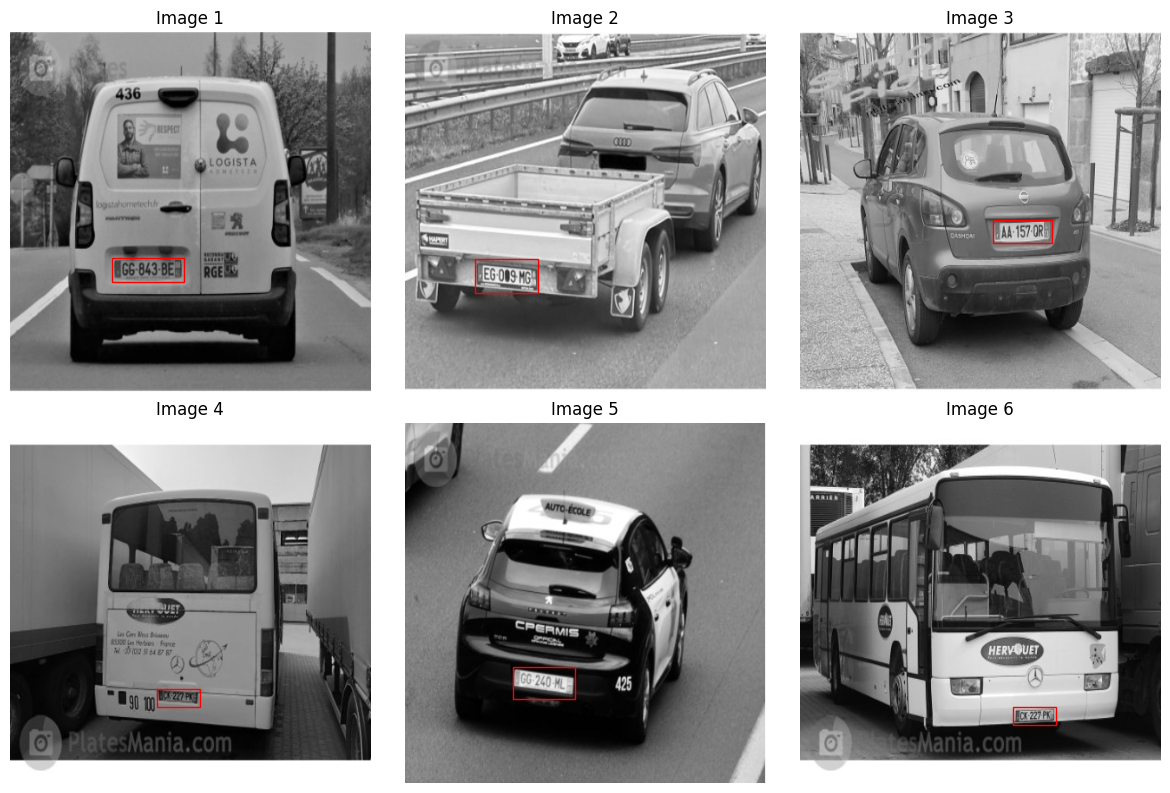

In [3]:
# Parcourir le DataLoader pour obtenir les 6 premiers éléments
num_images = 6
images_to_display = []
annotations_to_display = []
for images, annotations in dataloader:
    for image, annotation in zip(images, annotations):
        images_to_display.append(image)
        annotations_to_display.append(annotation)
        if len(images_to_display) >= num_images:
            break
    if len(images_to_display) >= num_images:
        break
# Affichage des images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    image = TF.to_pil_image(images_to_display[i])
    ax.imshow(image, cmap='gray')
    ax.axis("off")
    ax.set_title(f"Image {i+1}")
    # Dessiner les bounding boxes
    annotation = annotations_to_display[i]
    x_min, y_min, x_max, y_max = annotation.tolist()
    rect = plt.Rectangle(
        (x_min, y_min), x_max - x_min, y_max - y_min, edgecolor="r", facecolor="none"
    )
    ax.add_patch(rect)
plt.tight_layout()
plt.show()

## Building the network

In [4]:
class YOLO(nn.Module):
    def __init__(self, num_classes=0, num_boxes=1):
        super(YOLO, self).__init__()
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        # Couches de convolution pour extraire les caractéristiques de l'image
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        # Couches entièrement connectées pour prédire les bounding boxes
        self.fc1 = nn.Linear(256 * 13 * 13, 1024)
        self.fc2 = nn.Linear(
            1024, num_boxes * (4 + 1 + num_classes)
        )  # 4 pour les coordonnées + 1 pour la confiance + nombre de classes

    def forward(self, x):
        # Passer l'image à travers les couches de convolution
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # # Aplatir les caractéristiques pour les passer à travers les couches entièrement connectées
        x = x.view(-1, 256 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # # Redimensionner les sorties pour obtenir les prédictions de bounding boxes
        x = x.view(-1, 4 + 1 + self.num_classes)
        return x


# net = YOLO()
# input_data = torch.randn(13, 1, image_size, image_size)
# output_data = net(input_data)
# print("La taille de sortie :", output_data.size())
model = YOLO()
print(model)

YOLO(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=43264, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=5, bias=True)
)


## Training the model

In [5]:
# Optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Fonction de perte (YOLO Loss)
def yolo_loss(predictions, targets):
    # Supposer que predictions est un tensor de forme (batch_size, 5) représentant les prédictions
    # Supposer que targets est un tensor de forme (batch_size, 5) représentant les annotations (bboxes)
    # Calcul de la perte de localisation (MSE entre les prédictions et les annotations)
    localization_loss = torch.mean((predictions[:, :4] - targets[:, :4]) ** 2)
    # Supposons que les prédictions ont également une dimension pour la confiance (objectivité)
    # et que targets ont également des étiquettes de confiance correspondantes
    # Calcul de la perte d'objectivité (binary cross-entropy entre les prédictions et les annotations de confiance)
    confidence_loss = nn.BCEWithLogitsLoss()(predictions[:, 4:], targets[:, 4:])
    # Poids pour chaque perte
    lambda_coord = 5.0
    lambda_noobj = 0.5
    # Calcul de la perte totale
    total_loss = lambda_coord * localization_loss + lambda_noobj * confidence_loss
    return total_loss


def calculate_iou(boxes1, boxes2):
    # boxes1 et boxes2 sont des tenseurs de forme (N, 4) contenant les coordonnées des bboxes
    # où N est le nombre de bboxes dans chaque tenseur
    # Initialiser un vecteur pour stocker l'IoU de chaque paire
    iou_vector = torch.zeros(boxes1.shape[0])
    for i in range(boxes1.shape[0]):
        # Coordonnées de la boîte i de boxes1
        box1 = boxes1[i]
        # Coordonnées des boîtes de boxes2
        box2 = boxes2[i]
        # Calcul des coordonnées des boîtes d'intersection
        x_min = torch.max(box1[0], box2[0])
        y_min = torch.max(box1[1], box2[1])
        x_max = torch.min(box1[2], box2[2])
        y_max = torch.min(box1[3], box2[3])
        # Calcul de la surface de l'intersection
        intersection_area = torch.clamp(x_max - x_min, min=0) * torch.clamp(
            y_max - y_min, min=0
        )
        # Calcul des surfaces des boîtes
        area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        # Calcul de l'Union
        union_area = area_box1 + area_box2 - intersection_area
        # Calcul de l'IoU
        iou = intersection_area / union_area
        # Stocker l'IoU dans le vecteur
        iou_vector[i] = iou
    return iou_vector


# Boucle d'entraînement
num_epochs = 10
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, annotations in dataloader:
        images = images.to(device)
        annotations = annotations.to(device)
        # Réinitialiser les gradients
        optimizer.zero_grad()
        # Propagation avant
        predictions = model(images)
        # Initialiser les étiquettes de confiance pour les targets
        # Calculer l'Intersection over Union (IoU) entre les prédictions et les vérités terrain
        iou = calculate_iou(predictions[:, :4], annotations)
        # Initialiser les étiquettes de confiance
        confidence_labels = torch.zeros_like(iou)
        confidence_labels[iou >= 0.5] = 1  # Assigner 1 aux boîtes positives
        # Ensuite, concaténer les coordonnées des bboxes avec les étiquettes de confiance
        targets = torch.cat((annotations, confidence_labels.view(-1, 1)), dim=1)
        # Calcul de la perte
        loss = yolo_loss(predictions, targets)
        # Rétropropagation
        loss.backward()
        # Mise à jour des poids
        optimizer.step()
        train_losses.append(loss.item())
        running_loss += loss.item()
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 267716.5586
Epoch [2/10], Loss: 52727.4619
Epoch [3/10], Loss: 26821.3220
Epoch [4/10], Loss: 37490.4414
Epoch [5/10], Loss: 19989.0018
Epoch [6/10], Loss: 23414.5044
Epoch [7/10], Loss: 17259.6779
Epoch [8/10], Loss: 15204.9554
Epoch [9/10], Loss: 13864.8223
Epoch [10/10], Loss: 13974.3330


## Evaluating the model's Performance

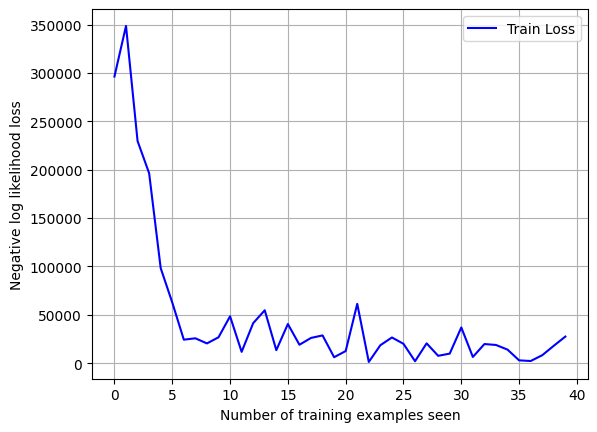

In [6]:
# Create a new figure for plotting
fig = plt.figure()

# Plot training losses as a blue line
plt.plot(train_losses, color="blue")
plt.grid(True)

# Add legend and labels
plt.legend(["Train Loss"], loc="upper right")
plt.xlabel("Number of training examples seen")
plt.ylabel("Negative log likelihood loss")

# Display the plot
plt.show()

In [8]:
batch_images, batch_annotations = next(iter(dataloader))
model.eval()
with torch.no_grad():
    predictions = model(batch_images)
print("iou :", calculate_iou(predictions[:4], batch_annotations))

iou : tensor([0.0000, 0.0410])
